In [46]:
import numpy as np
import pandas as pd
import random
import math
import requests
import matplotlib.pyplot as plt
from io import StringIO
from mpl_toolkits.mplot3d import Axes3D

In [47]:
url = "http://172.20.241.11/csv_from_data.php"
# Luodaan timeout value
try:
  response = requests.get(url, timeout=30)

  # Tarkistetaan toimivuus
  if response.status_code == 200:
    csv_data = response.text              # Haetaan CSV data tekstiksi.
    data = StringIO(response.text)        # Muutetaan teksti fileen
    df = pd.read_csv(data)                # Luetaan CSV dataframeen

    # Muutetaan saatu dataframe numpy taulukoksi.
    numpyTaulu = df[['id','x','y','z','direction']].to_numpy()
    print("Numpy taulukko jossa tiedot= id, x, y, z, direction.")
    print(numpyTaulu)

  else:
    print(f"Virhe hakemisessa: {response.status_code}")

except requests.exceptions.Timeout:
  print(f"Yhteyden muodostaminen osoitteeseen {url} aikakatkaistiin :(")
except requests.exceptions.RequestException as e:
  print(f"Virhe hakemisessa: {e}")

Numpy taulukko jossa tiedot= id, x, y, z, direction.
[[    1  1662  1638  2003     0]
 [    2  1659  1641  1998     0]
 [    3  1662  1633  2003     0]
 ...
 [35890  1343  1624  1752     5]
 [35891  1357  1684  1704     5]
 [35892  1303  1625  1665     5]]


In [48]:
#määrittelyjä
# Valitaan halutut arvot taulusta.
X = numpyTaulu[:, 1:5]

# Asetaan alkuarvot
k = 6 # Klusterien määrä
numberOfRows = X.shape[0]

# Arvotaan alkuperäiset keskipisteet
centroids = X[np.random.choice(X.shape[0], k, replace=False)]

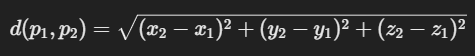

In [49]:
# Euklidisen etäisyyden määrittely
def euclideanDistance(p1, p2):
    # Lasketaan etäisyydet kaavan mukaan
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))
    # Tässä tapahtuu seuraavaa
    # zip(p1, p2) Yhdistää kaksi taulukkoa elementti kerrallaan.
    # (a - b) ** 2 laskee jokaisen koordinaatin (x, y, z) erotuksen neliön
    # math.sqrt ottaa koko summasta neliöjuuren joka määrittää euklidisen etäisyyden
p1 = X[0, 0:3]
p2 = X [1, 0:3]
distance = euclideanDistance(p1, p2)
print(f"Esimerkki etäisyys on= {distance}")
# Tämän voi myös suorittää näin käyttämällä valmista kirjastoa.
# def euclideanDistance(p1, p2):
#    return np.linalg.norm(p1 - p2)

Esimerkki etäisyys on= 6.557438524302


Kokeilin kmeans funktiota ilman valmiskirjastoa sekoitti 3D plottauksen niin otin kirjastot käyttöön

In [51]:
# K-means algoritmin iteraatio
converged = False                                       
iteration = 0                                           
max_iterations = 100                                    

while not converged and iteration < max_iterations:     

    cluster_assignments = []                            
    for i in range(numberOfRows):                       
        distances = np.array([euclideanDistance(X[i], centroid) for centroid in centroids])  
        winner = np.argmin(distances)                   
        cluster_assignments.append(winner)              

    cluster_assignments = np.array(cluster_assignments) 

    # Step 2: Päivitetään keskipisteet
    new_centroids = np.zeros((k, 4))                    
    counts = np.zeros(k)                                

    for i in range(numberOfRows):                       
        cluster = cluster_assignments[i]                
        new_centroids[cluster] += X[i]                  
        counts[cluster] += 1                            

    # Varmistetaan, ettei keskipisteet jää nollaksi
    for i in range(k):
        if counts[i] > 0:
            new_centroids[i] = new_centroids[i] / counts[i]  
        else:
            # Jos klusteriin ei ole pisteitä, arvotaan uusi keskipiste satunnaisesti
            new_centroids[i] = X[np.random.choice(X.shape[0])]

    # Tarkistetaan, onko keskipisteet muuttuneet riittävästi
    converged = True                                    
    for i in range(k):                                  
        if any(abs(new_centroids[i][j] - centroids[i][j]) > 1e-4 for j in range(3)):  
            converged = False                           
            break

    centroids = new_centroids                           
    iteration += 1                                      

# Tulostetaan lopulliset keskipisteet
print("Keskipisteet:", centroids)


Keskipisteet: [[1.33229893e+03 1.64778739e+03 1.69874423e+03 5.00000000e+00]
 [1.82679296e+03 1.66682999e+03 1.50255391e+03 2.50125376e+00]
 [1.66370490e+03 1.63670122e+03 2.00203010e+03 0.00000000e+00]
 [1.64425080e+03 1.33845402e+03 1.66809325e+03 2.00000000e+00]
 [1.66212698e+03 1.96914002e+03 1.65568571e+03 2.99966583e+00]
 [1.63996907e+03 1.31172093e+03 1.64576270e+03 2.00000000e+00]]


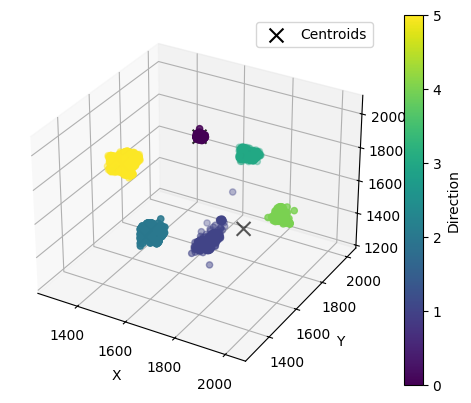

In [52]:
# Luodaan keskipisteistä tiedosto
np.savetxt('keskipisteet.h', centroids, delimiter=',')

# Visualisoidaan tulos 3D-kuvana
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with coloring by direction
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 3], cmap='viridis')  # Color by direction

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='black', marker='x', s=100, label='Centroids')

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Add color bar for direction
fig.colorbar(scatter, ax=ax, label='Direction')
plt.show()